# Domain quantization of video frames

In [2]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm

def normal_distribution(n, mean, var=0.05):
    x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
    x = x / np.sum(x)
    #return torch.tensor(x).float()
    return x

In [114]:
import pandas as pd

class DomainQuantizationLayer(nn.Module):
    def __init__(self, input_features, bin_count=10, init_low_bound=0.0, init_high_bound=1.0):
        assert bin_count > 1

        super().__init__()
        self.input_features = input_features
        self.bin_count = bin_count
        self.bins = [[] for _ in range(input_features)]
        self.bins_initialized = False
        self.values_used = 0

    def forward(self, input):
        assert input.shape[0] == self.input_features, f"self.input_features is {self.input_features}, input is {input.shape}"

        # print('input shape = ', input.shape)
        if self.training or not self.bins_initialized:
            self.update_bins(input)
        return self.map_values(input)

    def extra_repr(self):
        return f"input_features = {self.input_features}, resolution = {self.resolution}"
    
    def qcut_bins(self, values):
        assert len(values.shape) == 1, "Need 1D numpy array of values"
        _, bins = pd.qcut(values, q=self.bin_count-1, retbins=True, duplicates='drop', labels=False)
        return bins

    def map_values(self, values):
        output = torch.stack([self.map_feature_values(feature_values, feature_index) for feature_index, feature_values in enumerate(values)])
        return output
        
    def map_feature_values(self, values, feature_index):
        assert len(values.shape) == 1

        bins = self.bins[feature_index]
        digits = np.digitize(values, bins)
        output = digits.astype(float)
        for index, digit in enumerate(digits):
            if digit > 0 and digit < len(bins):
                val_left = bins[digit-1]
                val_right = bins[digit]
                output[index] += (values[index] - val_left) / (val_right - val_left)

        output -= 1
        output.clip(0, len(bins) - 1, out=output)
        #output = [normal_distribution(self.bin_count, item * 1.0 / self.bin_count) for item in output]
        return torch.Tensor(output)
    
    def update_bins(self, values):
        alpha = self.values_used / (self.values_used + values.size)
        
        for feature_index, feature_values in enumerate(values):
            self.update_feature_bins(feature_values, feature_index, alpha)
            
        self.bins_initialized = True
        self.values_used += values.shape[-1]
        if self.values_used > 10000:
            self.values_used = 10000
        
    def update_feature_bins(self, values, feature_index, alpha):
        
        bins = self.qcut_bins(values)

        if not self.bins_initialized or self.bins[feature_index].shape[0] < bins.shape[0]:
            self.bins[feature_index] = bins
        else:
            if self.bins[feature_index].shape[0] == bins.shape[0]:
                self.bins[feature_index] = self.bins[feature_index] * alpha + bins * (1 - alpha)
            else:
                pass # ignore smaller size bins, we never want to reduce resolution


In [115]:
from scipy.ndimage.filters import gaussian_filter
def generate_frames():
    width = 20
    height = 20
    gutter = 10

    frames = []

    for y in range(gutter-5, gutter+height-5):
        for x in range(width+2*gutter):
            frame = np.zeros((width + 2 * gutter, height + 2 * gutter))
            frame[y:10+y, x:x+3] = 1
            frame=gaussian_filter(frame, 0.5)
            clipped = frame[gutter:-gutter, gutter:-gutter]
            frames.append(clipped)

    return np.asarray(frames)

X = generate_frames()

In [116]:
frame_count, width, height = X.shape
X = X.reshape(frame_count, width * height)
print(X.shape)
feature_count = width * height
dq = DomainQuantizationLayer(feature_count, bin_count=200)

(800, 400)


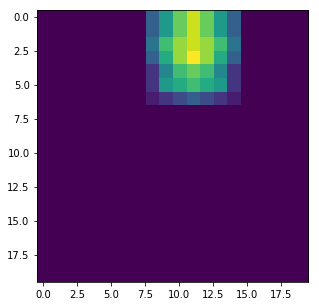

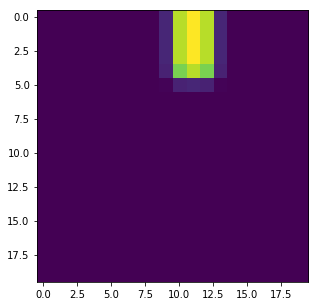

In [117]:
batch_start_index = 0
for batch in range(1):
    batch_size = frame_count
    pixel_data = X[batch_start_index:batch_start_index+batch_size,:].transpose()
    output = dq(pixel_data)

    # dq = DomainQuantizationLayer(X.shape[-1], bin_count=20)
    # output = dq(X.transpose())

    output_sample = output[:, 20].numpy().reshape(height, width)
    fig, ax1 = plt.subplots(figsize=(15, 5))
    ax1.imshow(output_sample)
    plt.show()

    input_sample = X[batch_start_index+20].reshape(height, width)
    fig, ax1 = plt.subplots(figsize=(15, 5))
    ax1.imshow(input_sample)
    plt.show()

#     fig, ax1 = plt.subplots(figsize=(15, 5))
#     ax1.imshow(output_sample - input_sample)
#     plt.show()

    batch_start_index += batch_size

In [112]:
dq.bins

[array([0.00000000e+00, 2.81582665e-05, 2.35706816e-04, 2.63783912e-04,
        2.63865083e-04, 8.52033739e-02, 1.05462513e-01, 1.06714637e-01,
        7.97958740e-01, 8.93274703e-01, 8.93285363e-01, 9.97611712e-01,
        9.99472270e-01]),
 array([0.00000000e+00, 2.81582665e-05, 2.35706816e-04, 2.63783912e-04,
        2.63865083e-04, 8.52033739e-02, 1.05462513e-01, 1.06714637e-01,
        7.97958740e-01, 8.93274703e-01, 8.93285363e-01, 9.97611712e-01,
        9.99472270e-01]),
 array([0.00000000e+00, 2.81582665e-05, 2.35706816e-04, 2.63783912e-04,
        2.63865083e-04, 8.52033739e-02, 1.05462513e-01, 1.06714637e-01,
        7.97958740e-01, 8.93274703e-01, 8.93285363e-01, 9.97611712e-01,
        9.99472270e-01]),
 array([0.00000000e+00, 2.81582665e-05, 2.35706816e-04, 2.63783912e-04,
        2.63865083e-04, 8.52033739e-02, 1.05462513e-01, 1.06714637e-01,
        7.97958740e-01, 8.93274703e-01, 8.93285363e-01, 9.97611712e-01,
        9.99472270e-01]),
 array([0.00000000e+00, 2.815826

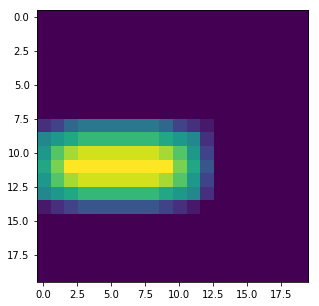

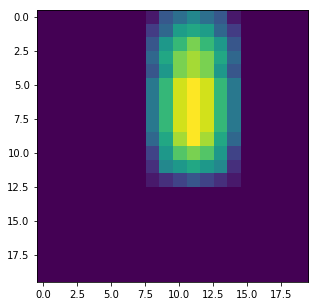

In [113]:
image = X[260].reshape(height, width).transpose().reshape(height * width)
dq.eval()

output = dq(image[:, None])
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.imshow(output.reshape(height, width))
plt.show()

output = dq(X[260][:, None])
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.imshow(output.reshape(height, width))
plt.show()